In [100]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [101]:
from vc_sample.density_estimation import KernelDensityEstimator
from vc_sample.kernels import GaussianKernel, kernel_scale_factor
from vc_sample.void_and_cluster import VoidAndCluster
from vc_sample import spectral_analysis

In [102]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Sampling in 1D

In [103]:
xs = np.linspace(0.0, 10.0, 100)
points = xs.reshape(-1, 1)

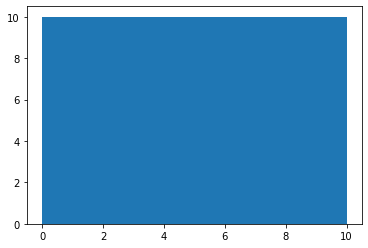

In [104]:
plt.hist(xs);

In [105]:
num_samples = 30

kernel_scale1d = 0.1 * kernel_scale_factor(dimensionality=1, num_points=100, num_samples=num_samples)
kernel_scale1d

0.33333333333333337

In [106]:
density_estimator = KernelDensityEstimator(points, GaussianKernel(sigma=kernel_scale1d))
vc = VoidAndCluster(density_estimator, points.shape[0], num_initial_samples=10)

sample_indices = vc.sample(size=num_samples)
samples = points[sample_indices]

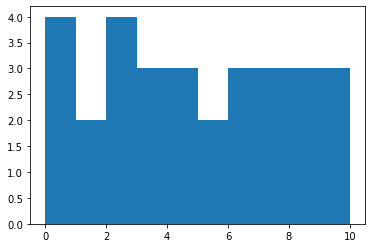

In [107]:
plt.hist(samples);

In contrast, random sampling gives very different results

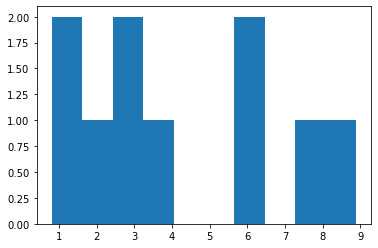

In [108]:
random_samples = np.random.choice(xs, replace=False, size=10)
plt.hist(random_samples);

## Sampling in 2D

In [109]:
num_points = 1000
xs = np.random.uniform(-1.0, 1.0, num_points)
ys = np.random.uniform(-1.0, 1.0, num_points)
points = np.stack([xs, ys]).T

In [110]:
kernel_bandwidth = 0.025 * kernel_scale_factor(dimensionality=2, num_points=num_points, num_samples=100)
kernel_bandwidth

0.0790569415042095

In [111]:
density_estimator = KernelDensityEstimator(points, GaussianKernel(sigma=kernel_bandwidth))
vc = VoidAndCluster(density_estimator, num_points, num_initial_samples=50)

sample_indices = vc.sample(size=100)
samples = points[sample_indices]

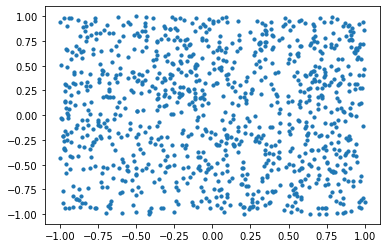

In [112]:
plt.scatter(x=points[:,0], y=points[:,1], s=10);

Not surprisingly, a spectral analysis using the Fourier transform does not show any structure in the data

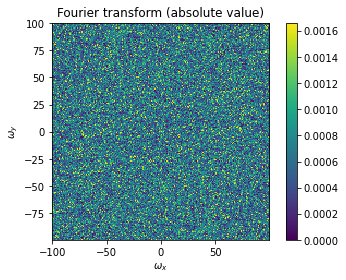

In [113]:
img_full = spectral_analysis.discretize_as_image(xs=points[:,0], ys=points[:,1], resolution=(200, 200))
spectral_analysis.plot_fourier_transform(img_full);

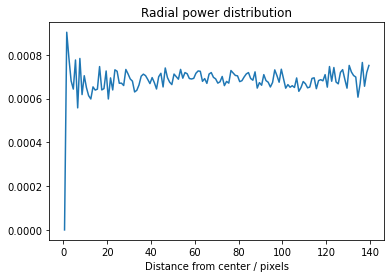

In [114]:
spectral_analysis.plot_power_distribution(img_full);

### Sampled Points

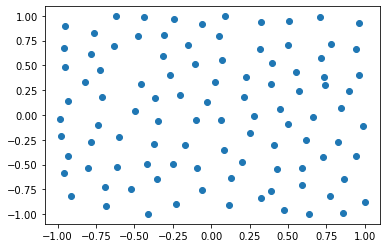

In [115]:
plt.scatter(x=samples[:,0], y=samples[:,1]);

Spectral analysis reveals _blue noise_, i.e. low frequencies have low energy (blue region in the Fourier transform plot)

In [116]:
img_sampled = spectral_analysis.discretize_as_image(xs=samples[:,0], ys=samples[:,1], resolution=(200, 200))

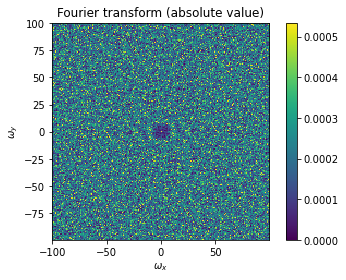

In [117]:
spectral_analysis.plot_fourier_transform(img_sampled);

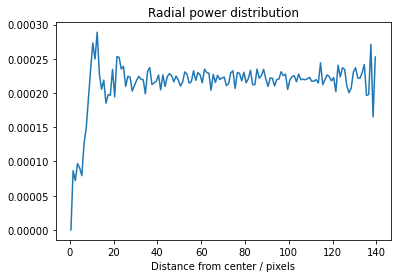

In [118]:
spectral_analysis.plot_power_distribution(img_sampled);

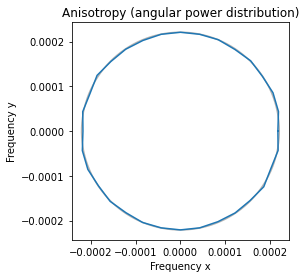

In [119]:
spectral_analysis.plot_anisotropy(img_sampled);

## Sampling a noisy sinus in 2D

In [124]:
num = 2000
num_samples = 200

ys = np.sin(np.linspace(-3.0, 3.0, num)) + np.random.normal(loc=0, scale=0.4, size=num)
xs = np.linspace(-3.0, 3.0, num)
points = np.stack([xs, ys]).T

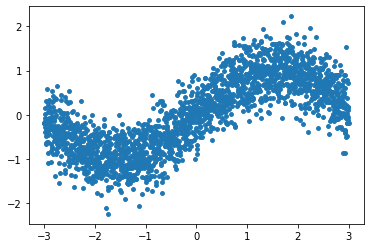

In [125]:
plt.scatter(xs, ys, s=15);

In [170]:
kernel_bandwidth = 0.055 * kernel_scale_factor(dimensionality=2, num_points=num_points, num_samples=num_samples)
kernel_bandwidth

0.12298373876248844

In [171]:
density_estimator = KernelDensityEstimator(points, GaussianKernel(sigma=kernel_bandwidth),
                                           divide_data_density=True)

The density estimation divides out the original density of the data so that samples are distributed just like the original data.

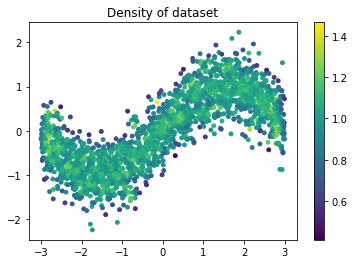

In [172]:
density = density_estimator.estimate()
plt.title('Density of dataset')
plt.scatter(xs, ys, c=density, s=15);
plt.colorbar();

In [173]:
vc = VoidAndCluster(density_estimator, points.shape[0], num_initial_samples=50)
sample_indices = vc.sample(size=num_samples)
samples = points[sample_indices]

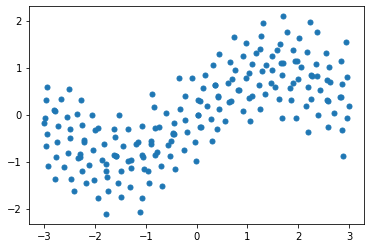

In [174]:
plt.scatter(x=samples[:,0], y=samples[:,1], s=25);

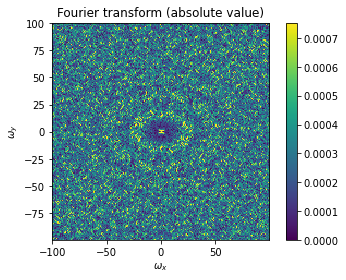

In [176]:
img_sampled = spectral_analysis.discretize_as_image(xs=samples[:,0], ys=samples[:,1], resolution=(200, 200))
spectral_analysis.plot_fourier_transform(img_sampled);

### Sampling with non-uniform probabilities in 2D

In [55]:
x = np.linspace(-1.0, 1.0, 60)
xy = np.outer(x, x)
xs = np.tile(x, x.shape)
ys = np.repeat(x, x.shape)
points = np.stack([xs, ys]).T

ps = np.clip(1 - np.abs(np.sin(xs*0.5)*2) + 0.1, 0.0, 1.0)

num_samples = 500
num_points = xs.shape[0]
num_points

3600

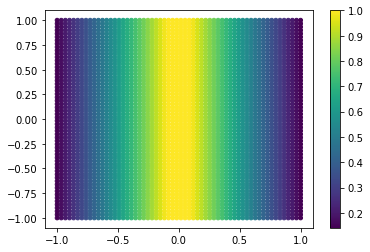

In [56]:
plt.scatter(xs, ys, c=ps, s=15);
plt.colorbar();

In [81]:
kernel_bandwidth = 0.015 * kernel_scale_factor(dimensionality=2, num_points=num_points, num_samples=num_samples)
kernel_bandwidth

0.04024922359499621

Non-uniform sampling is achieved by factoring it in (or rather its inverse) in the density estimation. 

In [82]:
density_estimator = KernelDensityEstimator(points, GaussianKernel(sigma=kernel_bandwidth),
                                           divide_data_density=True, importance=ps)
vc = VoidAndCluster(density_estimator, num_points, num_initial_samples=100)

sample_indices = vc.sample(size=num_samples)
samples = points[sample_indices]

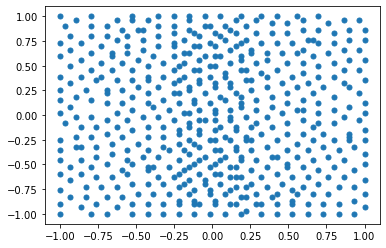

In [83]:
plt.scatter(samples[:,0], samples[:,1], s=25);

### Sampling a Gaussian in 3D

In [84]:
num = 1000
num_samples = 100

xs = np.random.normal(loc=0, scale=1.0, size=num)
ys = np.random.normal(loc=0, scale=1.0, size=num)
zs = np.random.normal(loc=0, scale=1.0, size=num)
points = np.stack([xs, ys, zs]).T

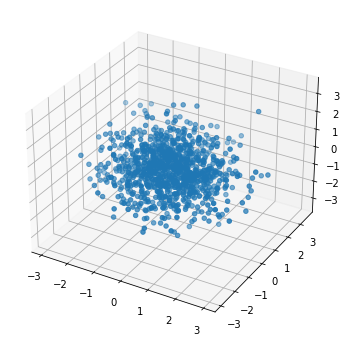

In [85]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs, ys, zs);

In [92]:
kernel_bandwidth = 0.25 * kernel_scale_factor(dimensionality=3, num_points=num_points, num_samples=num_samples)
kernel_bandwidth

0.8254818122236566

In [93]:
density_estimator = KernelDensityEstimator(points, GaussianKernel(sigma=kernel_bandwidth))

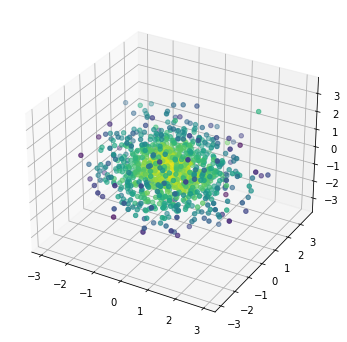

In [94]:
density = density_estimator.estimate()

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs, ys, zs, c=density);

In [95]:
vc = VoidAndCluster(density_estimator, points.shape[0], num_initial_samples=50)
sample_indices = vc.sample(size=num_samples)
samples = points[sample_indices]

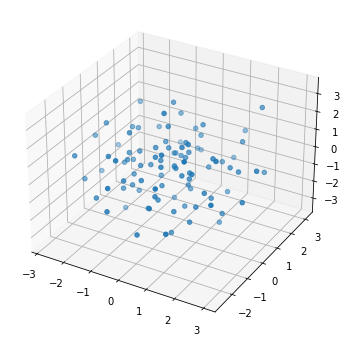

In [96]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(samples[:,0], samples[:,1], samples[:,2]);